In [51]:
%reload_ext autoreload

In [52]:
import boto3
import lambda_function
import cv2
import utils
import matplotlib.pyplot as plot
import color_images as ci
import numpy as np
import contour_utils
import templates
import drawing
import lobster_contour_utils
from importlib import reload


In [53]:
is_deployed = False

In [118]:
#imageName = "blue_bkground_data/2016-08-01 17_44_32.1A.jpg"
#imageName = "color_bkground_data/IMG_5709.JPG"
#gets dissolved too much
#imageName = "may_2017_data/IMG_7.68.JPG"

#imageName = "617_data/FrankPhotos/Glass_Beach_Memorial_Day_ - 48_191.jpg"
imageName = "lobster 3.10.18 Bella B/GOPR1744.JPG"
#imageName = "new_color_bkground_data/blue/Eric 12.jpg"
#imageName = "dec_bkground_data/IMG_60.jpg"
#imageName="color_bkground_data/IMG_5703.JPG"
showResults=True


orig cols: 3648, orig_rows: 2736


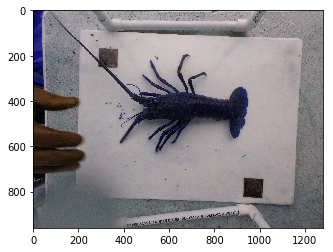

In [119]:
image_full = cv2.imread(imageName, cv2.IMREAD_COLOR)

#read the image
orig_cols = len(image_full[0]) 
orig_rows = len(image_full)

#if its vertical, flip it 90
if orig_cols < orig_rows:
    img = cv2.transpose(image_full)  
    img = cv2.flip(img, 0)
    image_full = img.copy()
    orig_cols = len(image_full[0])
    orig_rows = len(image_full)

rescaled_image, scaled_rows, scaled_cols = lambda_function.get_scaled_image(image_full)
plot.imshow(rescaled_image)

In [120]:
lobster_template_contour, small_lobster_template_contour, square_template_contour = templates.get_template_contours(rescaled_image,"lobster_templates/full_lobster_right.png", 
                                    "lobster_templates/full_lobster_left.png",
                                    "lobster_templates/square_templates_2inch.png")

is_white = utils.is_white_or_gray(rescaled_image)
mean_color = utils.get_mean_background_color(rescaled_image)
is_white


ruler file: lobster_templates/square_templates_2inch.png


False

img_center: (445, 340)
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
blew up on : only size-1 arrays can be converted to Python scalars
len targets: 1
num items: 10
center is:

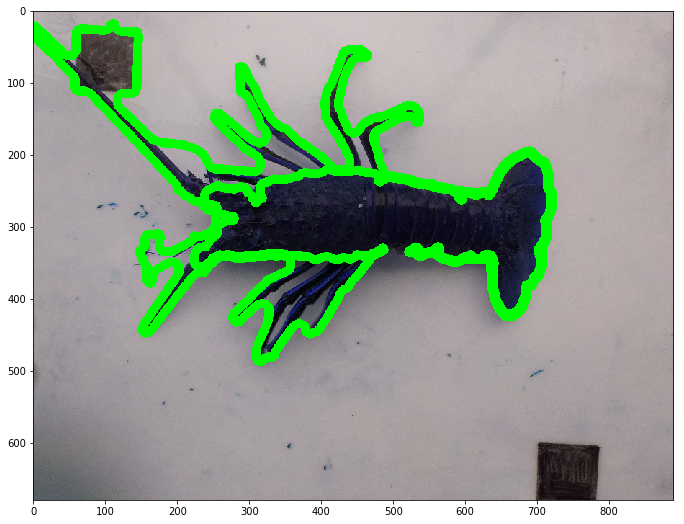

In [129]:
reload(lobster_contour_utils)
reload(utils)

white_or_gray = True
use_opposite = False
target_contour = None
new_drawing = rescaled_image.copy()
top_offset = 140
left_offset = 230
right_offset = 160
bottom_offset = 140
trimmed_image = new_drawing[top_offset:len(new_drawing) - bottom_offset,left_offset:len(new_drawing[0])-right_offset]

gray = utils.get_gray_image(trimmed_image, white_or_gray, use_opposite)
if use_opposite:
    white_or_gray = not white_or_gray
blur = cv2.GaussianBlur(gray, (5,5),0)
if white_or_gray:
    lower_bound = 50
    upper_bound = 100
else:
    lower_bound = 50
    upper_bound = 200

edged_img = cv2.Canny(blur, lower_bound, upper_bound,3) 

dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,17))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel = np.ones((3,3), np.uint8)
if not white_or_gray:
    iters = 2
else:
    iters=3
    
edged_img = cv2.dilate(edged_img, kernel, iterations=iters)
edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_CLOSE, dilate_kernel)

#check this - seems like dark on white needs a cleanup, color needs an thickening
if not white_or_gray:
    edged_img = cv2.dilate(edged_img, kernel, iterations=1)
else:
    edged_img = cv2.erode(edged_img, erode_kernel, iterations=1)


#gray_denoised = cv2.cvtColor(edged_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(edged_img.copy(), 127,255,0)
cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

all_contours = cnts[1]

ncols = len(trimmed_image[0]) 
nrows = len(trimmed_image)
img_area = nrows*ncols
minVal = 100000000
dex = 0
img_center = (int(ncols/2),int(nrows/2))
print("img_center: {}".format(img_center))

largest = utils.get_largest_contours(all_contours,10)

center_contours = []
for i, contour in enumerate(all_contours):
    hull = cv2.convexHull(contour)
    centerIn = cv2.pointPolygonTest(hull,img_center,False) >= 0
    print("center is: {}".format(center))
    if centerIn:
        print("got a hit")
        center_contours.append(contour)

largest = utils.get_largest_contours(center_contours,1)
print("largest: {}".format(largest))
target_contour = largest[0]
cv2.drawContours(trimmed_image, [target_contour], -1, (0,255,0),12)

plot.figure(figsize = (16,9))
plot.imshow(trimmed_image)

number of contours: 15


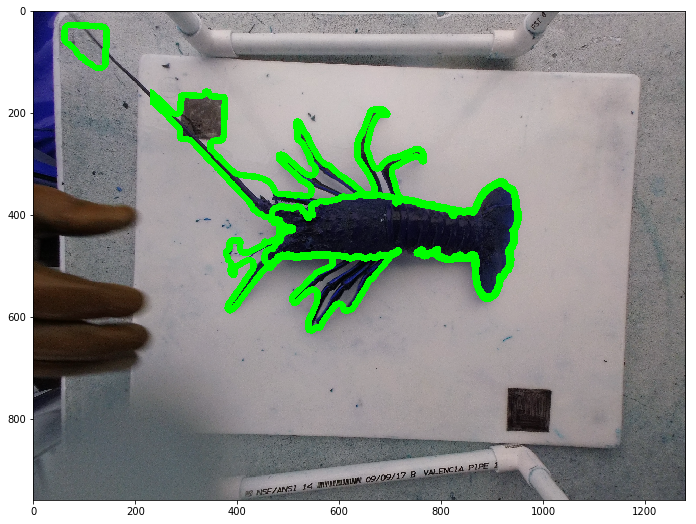

In [130]:
input_image = rescaled_image.copy()
white_or_gray = True
if not white_or_gray and not use_opposite:
    thresh_val = 30
    blur_window = 5
    first_pass = True
    is_ruler = True
    use_adaptive = False
    color_image, threshold_bw, color_img, mid_row = ci.get_image_with_color_mask(input_image, thresh_val, 
        blur_window, False, first_pass, is_ruler, use_adaptive)
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
else:
    denoised = cv2.fastNlMeansDenoisingColored(input_image,None,10,10,7,21)
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

if white_or_gray:
    lower_bound = 0
    upper_bound = 100
    thresh_lower = 70
    thresh_upper = 255
else:
    lower_bound = 20
    upper_bound = 250
    thresh_lower = 127
    thresh_upper = 250

scale_img = cv2.Canny(gray, lower_bound, upper_bound,7) 
#gray_denoised = cv2.cvtColor(edged_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(edged_img.copy(), 127,255,0)
cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = cnts[1]
print("number of contours: {}".format(len(contours)))
ncols = len(input_image[0]) 
nrows = len(input_image)
img_area = nrows*ncols
minVal = 100000000
dex = 0
for i, contour in enumerate(contours):
    try:
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)   
        contour_area = cv2.contourArea(contour)

        hull_perc = hull_area/img_area
        actual_perc = contour_area/img_area

        if actual_perc <= 0.3 and actual_perc > lower_percent_bounds:
            if(len(contour) == 0):
                continue

            x,y,w,h = cv2.boundingRect(contour)
            #ditch cutting board borders around the outside
            if w < 0.2*ncols and h < 0.2*nrows:

                val = cv2.matchShapes(contour, square_template_contour, 2, 0.0)
                val=val*(1/contour_area)

                if val < minVal:
                    dex = i
                    minVal = val

                target_contour = contours[dex]
    except Exception as e:
        print("error: {}".format(e))
        continue

cv2.drawContours(new_drawing, [target_contour], -1, (0,255,0),12)

plot.figure(figsize = (16,9))
plot.imshow(new_drawing)

pre is Ruler
db: 204, pixels per: 102.0; dim b: 2.0
pre is Abalone
db: 203, pixels per: 102.0; dim b: 1.9901960784313726


1.9901960784313726

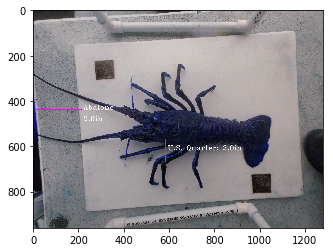

In [49]:
reload(drawing)
flipDrawing = orig_rows/orig_cols > 1.2
new_drawing = rescaled_image.copy()
pixelsPerMetric, rulerLength,left_ruler_point, right_ruler_point = drawing.draw_contour(new_drawing, 
    square_contour, None, "Ruler", True, flipDrawing, 2.0)
#base_img, contour, pixelsPerMetric, pre, draw_text, flipDrawing, rulerWidth
pixelsPerMetric, abaloneLength, left_point, right_point = drawing.draw_contour(new_drawing, 
    lobster_contour, pixelsPerMetric, "Abalone", True, flipDrawing, 2.0)

plot.imshow(new_drawing)
abaloneLength
